---
title: ML Algorithms in Numpy and PyTorch
description: ML Algorithms in Numpy and PyTorch
date: 2024-10
categories: [PyTorch]
---

In [118]:
import numpy as np
import torch
from sklearn import datasets
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
import collections

## KNN

- Predict the class based on the most common class among the k nearest neighbors
- fit: doesn't actually "train" the model in a traditional sense, just stores the training data.
- predict: for each point, find k nearest neighbors, then find most common class among these.

In [114]:
class KNN:
    def __init__(self,k=3):
        self.k = k

    def _dist(self,x1,x2):
        return np.sqrt(np.sum((x1-x2)**2))
    
    def fit(self,X,y):
        self.X_train = X
        self.y_train = y

    def _predict(self,x,debug=False):
        dists=np.array([self._dist(x,x_train) for x_train in self.X_train])
        sorted_indices = np.argsort(dists)[:self.k]
        labels = [self.y_train[i] for i in sorted_indices]
        most_common_labels = collections.Counter(labels).most_common(1)[0][0]
        if debug: 
            print("ORIGINAL: ",dists)
            print("LABELS: ",labels)
            print("MOST COMMON LABEL: ", most_common_labels)
        return most_common_labels
    
    def predict(self,X,debug):
        # X can have multiple samples, so predict for each one
        out = np.array([self._predict(x,debug) for x in X])
        if debug: print(out)
        return out


In [140]:

iris = datasets.load_iris()
X,y = iris.data, iris.target

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
def accuracy(y_true,y_pred):
    return np.sum(y_true==y_pred)/len(y_true)


k = 3
clf = KNN(k)
clf.fit(X_train,y_train)
predictions  = clf.predict(X_test,debug=False)
print("Accuracy: ", accuracy(y_test,predictions))


Accuracy:  1.0


- First implement a naive implementation by directly converting numpy arrays to torch.tensors and replacing numpy functions with PyTorch functions.

In [141]:
class KNNTorchNaive:
    def __init__(self,k=3):
        self.k = k

    def _dist(self,x1,x2):
        return torch.sqrt(torch.sum((x1-x2)**2))
    
    def fit(self,X,y):
        self.X_train = X
        self.y_train = y

    def _predict(self,x,debug=False):
        dists=torch.tensor([self._dist(x,x_train) for x_train in self.X_train])
        sorted_indices = torch.argsort(dists)[:self.k]
        labels = [self.y_train[i] for i in sorted_indices]
        most_common_labels = collections.Counter(labels).most_common(1)[0][0]
        if debug: 
            print("ORIGINAL: ",dists)
            print("LABELS: ",labels)
            print("MOST COMMON LABEL: ", most_common_labels)
        return most_common_labels
    
    def predict(self,X,debug):
        # X can have multiple samples, so predict for each one
        out = torch.tensor([self._predict(x,debug) for x in X])
        if debug: print(out)
        return out

In [142]:
k = 3
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)
def accuracy(y_true,y_pred): return torch.sum(y_true==y_pred).item()/len(y_true)
clf = KNNTorchNaive(k)
clf.fit(X_train,y_train)
predictions  = clf.predict(X_test,debug=False)
print("Accuracy: ", accuracy(y_test,predictions))

Accuracy:  1.0


In [126]:
X_train.shape

torch.Size([120, 4])

In [156]:
class KNNTorchBroadcast:
    def __init__(self,k=3):
        self.k = k
    
    def fit(self,X,y):
        self.X_train = X
        self.y_train = y

    def _predict(self,x,debug=False):
        #print(x.shape)
        dists = torch.sqrt(torch.sum((self.X_train-x)**2,dim=1))
        sorted_indices = torch.argsort(dists)[:self.k]
        labels = [self.y_train[i] for i in sorted_indices] #could perhaps be optimized, but trying to keep this consistent with collections.Counter
        most_common_labels = collections.Counter(labels).most_common(1)[0][0]
        if debug: 
            print("ORIGINAL: ",dists)
            print("LABELS: ",labels)
            print("MOST COMMON LABEL: ", most_common_labels)
        return most_common_labels
    
    def predict(self,X,debug):
        # X can have multiple samples, so predict for each one
        out = torch.tensor([self._predict(x,debug) for x in X])
        if debug: print(out)
        return out

- Broadcasting in PyTorch follows these rules:

1. If the two tensors differ in the number of dimensions, the shape of the tensor with fewer dimensions is padded with ones on its leading (left) side.

2. If the shape of the two tensors does not match in any dimension, the tensor with shape equal to 1 in that dimension is stretched to match the other shape.

3. If in any dimension the sizes disagree and neither is equal to 1, an error is raised.

- We subtract tensor `x` of shape `[4]` from a tensor `self.X_train` of shape `[120, 4]`, PyTorch automatically broadcasts `x` to the shape of `self.X_train` by repeating it along the 0th dimension.
    - In the *dists* calculation, the tensors differ in number of dimensions, so `x` is padded on the left with 1, becoming `[1,4]` according to Rule 1.  Then by Rule 2, this resulting tensor is "stretched out" along 0th dimension from shape `[1,4]` to `[120,4]`.

In [157]:
def accuracy(y_true,y_pred): return torch.sum(y_true==y_pred).item()/len(y_true)
clf = KNNTorchBroadcast(k)
clf.fit(X_train,y_train)
predictions  = clf.predict(X_test,debug=False)
print("Accuracy: ", accuracy(y_test,predictions))

Accuracy:  1.0


## K-Means Clustering

- Cluster an unlabeled data set into K clusters.  
    - Initialize cluster centroids randomly
    - Repeat until convergence
        - Update cluster labels, assigning points to nearest cluster centroid
        - Update cluster centroids, setting them to the mean of each cluster

In [3]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)


In [129]:
class KMeans:
    def __init__(self, K, max_iters, plot_steps):
        self.K = K
        self.max_iters = max_iters
        self.plot_steps = plot_steps
        # list of lists of indices for each cluster
        self.clusters = [[] for _ in range(self.K)]
        # mean feature vector for each cluster
        self.centroids = []
        self.tol = 1e-20
    def _dist(self,x1,x2):
        return np.sqrt(np.sum((x1-x2)**2))
    # just need predict since unsupervised with no labels
    def predict(self,X,debug=False):
        self.X = X #just need for plotting
        self.n_samples, self.n_features = X.shape
        # initialize cluster centroids randomly
        self.centroids =[self.X[idx] for idx in np.random.choice(self.n_samples, size=self.K, replace=False)]
        if debug: print('init centroids: ', self.centroids); print('init clusters: ',self.clusters)
        for it in range(self.max_iters):
            # Re-initialize the clusters since else will keep appending to old ones!!! (IMPORTANT)
            self.clusters = [[] for _ in range(self.K)]
            old_centroids = np.copy(self.centroids) #else will point to self.centroids even when those are re-initialized! (IMPORTANT)
            # Update cluster labels, assigning points to nearest cluster centroid
            for i in range(self.n_samples):
                cluster_idx = np.argmin([self._dist(self.X[i,:],centroid) for centroid in self.centroids])
                self.clusters[cluster_idx].append(i)
            # Update cluster centroids, setting them to the mean of each cluster
            for i,cluster in enumerate(self.clusters):
                self.centroids[i] = np.mean([self.X[idx] for idx in cluster], axis = 0)
                
            if debug: print('centroids: ', self.centroids); print('clusters: ',self.clusters)
            if np.all([self._dist(old_centroids[i], self.centroids[i]) < self.tol for i in range(self.K)]):
                print(f'converged in {it} iterations, breaking'); break
        
    def plot(self):
        """From https://github.com/patrickloeber/MLfromscratch/blob/master/mlfromscratch/kmeans.py"""
        fig, ax = plt.subplots(figsize=(12, 8))

        for i, index in enumerate(self.clusters):
            point = self.X[index].T
            ax.scatter(*point)

        for point in self.centroids:
            ax.scatter(*point, marker="x", color="black", linewidth=2)

        plt.show()

(5000, 2)
3
converged in 8 iterations, breaking
Time taken: 0.36868009900172183


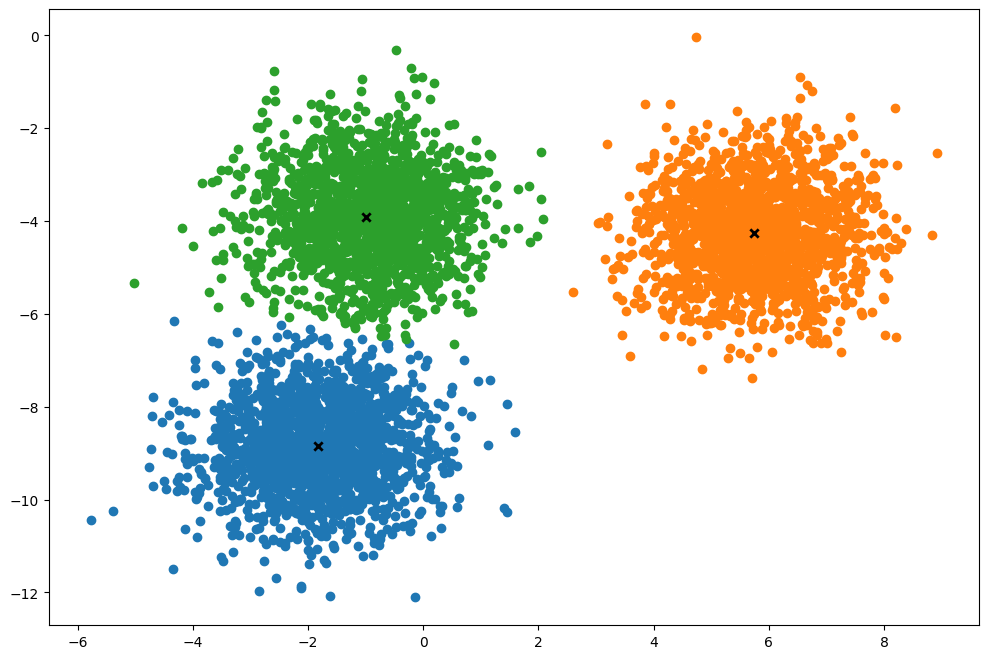

In [204]:
from sklearn.datasets import make_blobs
from time import perf_counter
start_time=perf_counter()
X, y = make_blobs(
    centers=3, n_samples=5000, n_features=2, shuffle=True, random_state=40
)
print(X.shape)

clusters = len(np.unique(y))
print(clusters)

k = KMeans(K=clusters, max_iters=150, plot_steps=True)
y_pred = k.predict(X,debug = False)
end_time = perf_counter()
print(f"Time taken: {end_time-start_time}")
k.plot()


In [207]:
class KMeansVectDist:
    def __init__(self, K, max_iters, plot_steps):
        self.K = K
        self.max_iters = max_iters
        self.plot_steps = plot_steps
        self.clusters = [[] for _ in range(self.K)]
        self.centroids = []
        self.tol = 1e-20

    def predict(self, X, debug=False):
        self.X = X
        self.n_samples, self.n_features = X.shape
        self.centroids = self.X[np.random.choice(self.n_samples, size=self.K, replace=False)]

        for it in range(self.max_iters):
            self.clusters = [[] for _ in range(self.K)]
            old_centroids = np.copy(self.centroids)

            distances = np.sqrt(((self.X - self.centroids[:, np.newaxis])**2).sum(axis=2))
            closest_clusters = np.argmin(distances, axis=0)
            for i in range(self.n_samples):
                self.clusters[closest_clusters[i]].append(i)

            for i, cluster in enumerate(self.clusters):
                self.centroids[i] = self.X[cluster].mean(axis=0)

            if np.all(np.sqrt(np.sum((old_centroids - self.centroids) ** 2, axis=1)) < self.tol):
                print(f'converged in {it} iterations, breaking')
                break
    def plot(self):
        """From https://github.com/patrickloeber/MLfromscratch/blob/master/mlfromscratch/kmeans.py"""
        fig, ax = plt.subplots(figsize=(12, 8))

        for i, index in enumerate(self.clusters):
            point = self.X[index].T
            ax.scatter(*point)

        for point in self.centroids:
            ax.scatter(*point, marker="x", color="black", linewidth=2)

        plt.show()

(5000, 2)
3
converged in 7 iterations, breaking
Time taken: 0.0077601640005013905


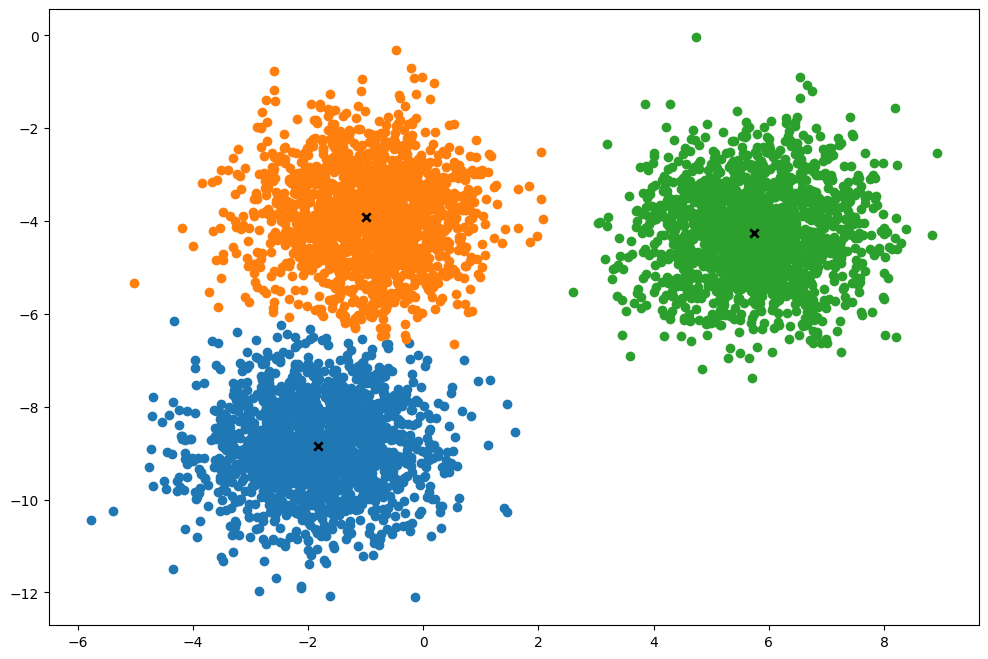

In [208]:
from sklearn.datasets import make_blobs
from time import perf_counter
start_time=perf_counter()
X, y = make_blobs(
    centers=3, n_samples=5000, n_features=2, shuffle=True, random_state=40
)
print(X.shape)

clusters = len(np.unique(y))
print(clusters)

k = KMeansVectDist(K=clusters, max_iters=150, plot_steps=True)
y_pred = k.predict(X,debug = False)
end_time = perf_counter()
print(f"Time taken: {end_time-start_time}")
k.plot()


- `torch.tensor()` vs `torch.stack()`:
    The `torch.tensor()` function is used to create a new tensor, while `torch.stack()` is used to concatenate a sequence of tensors along a new dimension. 

    In our case, `[torch.mean(self.X[cluster], axis=0) for cluster in self.clusters]` is a list of tensors. Each tensor is the mean of the data points in a cluster. 

    If we use `torch.tensor()` on this list, it will try to create a new tensor that contains these tensors, which is not allowed because all elements within a tensor must be of the same type and tensors cannot contain other tensors.

    On the other hand, `torch.stack()` takes this list of tensors and concatenates them along a new dimension to create a single tensor. This is why `torch.stack()` is used in this case.

    In short, `torch.stack()` is used to combine existing tensors into a larger tensor, while `torch.tensor()` is used to create a new tensor.

In [153]:
import torch
class KMeansTorchNaive:
    def __init__(self, K, max_iters, plot_steps):
        self.K = K
        self.max_iters = max_iters
        self.plot_steps = plot_steps
        # list of lists of indices for each cluster
        self.clusters = [[] for _ in range(self.K)]
        # mean feature vector for each cluster
        self.centroids = []
        self.tol = 1e-20
    def _dist(self,x1,x2):
        return torch.sqrt(torch.sum((x1-x2)**2))
    # just need predict since unsupervised with no labels
    def predict(self,X,debug=False):
        self.X = X #just need for plotting
        self.n_samples, self.n_features = X.shape
        # initialize cluster centroids randomly
        #self.centroids =[self.X[idx] for idx in torch.random.choice(self.n_samples, size=self.K, replace=False)]
        self.centroids = self.X[torch.randperm(self.n_samples)[:self.K]]

        if debug: print('init centroids: ', self.centroids); print('init clusters: ',self.clusters)
        for it in range(self.max_iters):
            # Re-initialize the clusters since else will keep appending to old ones!!! (IMPORTANT)
            self.clusters = [[] for _ in range(self.K)]
            old_centroids = self.centroids.clone()
            # Update cluster labels, assigning points to nearest cluster centroid
            for i in range(self.n_samples):
                cluster_idx = torch.argmin(torch.tensor(torch.tensor([self._dist(self.X[i,:],centroid) for centroid in self.centroids])))
                self.clusters[cluster_idx].append(i)
            # Update cluster centroids, setting them to the mean of each cluster
            # for i,cluster in enumerate(self.clusters):
            #     self.centroids[i] = torch.mean(torch.tensor([self.X[idx] for idx in cluster]))
            self.centroids = torch.stack([torch.mean(self.X[cluster], axis=0) for cluster in self.clusters])
            if debug: print('centroids: ', self.centroids); print('clusters: ',self.clusters)
            if torch.all(torch.sqrt(torch.sum((self.centroids-old_centroids)**2,dim=1)) < self.tol): 
            #if np.all([self._dist(old_centroids[i], self.centroids[i]) < self.tol for i in range(self.K)]):
                print(f'converged in {it} iterations, breaking'); break
            # if torch.all([self._dist(old_centroids[i], self.centroids[i]) < self.tol for i in range(self.K)]):
            #     print(f'converged in {it} iterations, breaking'); break
        
    def plot(self):
        """From https://github.com/patrickloeber/MLfromscratch/blob/master/mlfromscratch/kmeans.py"""
        fig, ax = plt.subplots(figsize=(12, 8))

        for i, index in enumerate(self.clusters):
            point = self.X[index].T
            ax.scatter(*point)

        for point in self.centroids:
            ax.scatter(*point, marker="x", color="black", linewidth=2)

        plt.show()

torch.Size([5000, 2])
3


/tmp/ipykernel_8198/1886197135.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cluster_idx = torch.argmin(torch.tensor(torch.tensor([self._dist(self.X[i,:],centroid) for centroid in self.centroids])))


converged in 5 iterations, breaking
Time taken: 0.8377222439994512


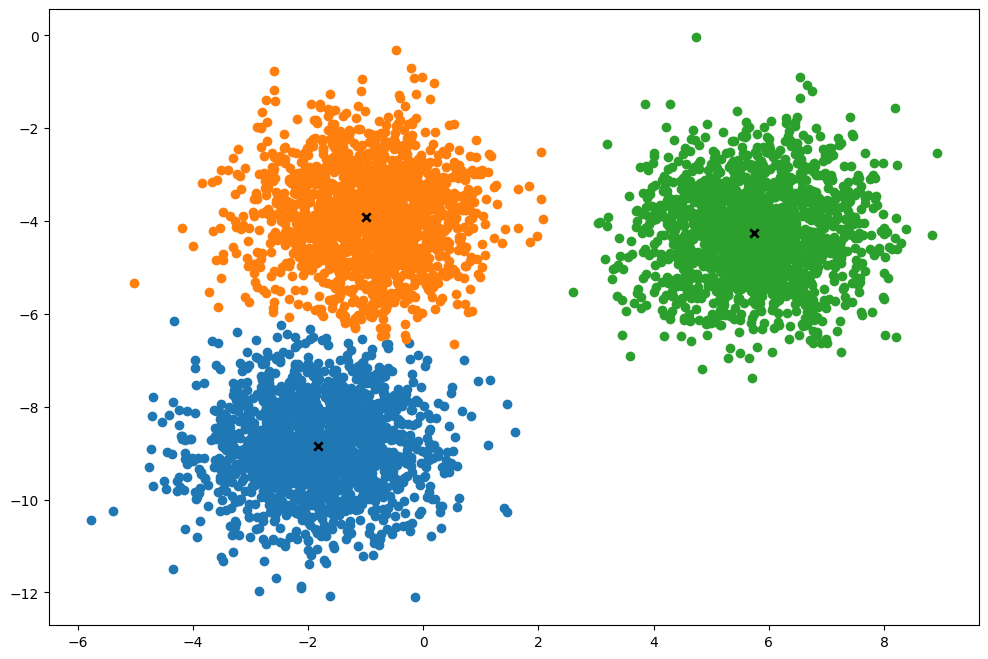

In [198]:
from sklearn.datasets import make_blobs
from time import perf_counter
start_time = perf_counter()
X, y = make_blobs(
    centers=3, n_samples=5000, n_features=2, shuffle=True, random_state=40
)
X, y = torch.tensor(X), torch.tensor(y)
print(X.shape)

clusters = len(np.unique(y))
print(clusters)

k = KMeansTorchNaive(K=clusters, max_iters=150, plot_steps=True)
y_pred = k.predict(X,debug = False)
end_time = perf_counter()
print(f"Time taken: {end_time-start_time}")
k.plot()

- OK, naive PyTorch implementation took a bit longer than basic numpy implementation.

In [169]:
import torch
class KMeansTorch:
    def __init__(self, K, max_iters, plot_steps):
        self.K = K
        self.max_iters = max_iters
        self.plot_steps = plot_steps
        # list of lists of indices for each cluster
        self.clusters = [[] for _ in range(self.K)]
        # mean feature vector for each cluster
        self.centroids = []
        self.tol = 1e-20
    def _dist(self,x1,x2):
        return torch.sqrt(torch.sum((x1-x2)**2))
    # just need predict since unsupervised with no labels
    def predict(self,X,debug=False):
        self.X = X #just need for plotting
        self.n_samples, self.n_features = X.shape
        # initialize cluster centroids randomly
        self.centroids = self.X[torch.randperm(self.n_samples)[:self.K]]

        if debug: print('init centroids: ', self.centroids); print('init clusters: ',self.clusters)
        for it in range(self.max_iters):
            # Re-initialize the clusters since else will keep appending to old ones!!! (IMPORTANT)
            self.clusters = [[] for _ in range(self.K)]
            old_centroids = self.centroids.clone()
            distances = torch.cdist(self.X, self.centroids) # The value at position [i, j] is the distance from data point i to centroid j
            if debug: print(f"Distances shape: {distances.shape}")
            closest_centroids = torch.argmin(distances, dim = 1)
            if debug: print(f"Closest centroids: {closest_centroids}")
            self.clusters = [list((closest_centroids==i).nonzero(as_tuple=True)[0].cpu().numpy()) for i in range(self.centroids.shape[0])]
            self.centroids = torch.stack([torch.mean(self.X[cluster], axis=0) for cluster in self.clusters])
            if debug: print('centroids: ', self.centroids); print('clusters: ',self.clusters)
            if torch.all(torch.sqrt(torch.sum((self.centroids-old_centroids)**2,dim=1)) < self.tol): 
                print(f'converged in {it} iterations, breaking'); break
        
    def plot(self):
        """From https://github.com/patrickloeber/MLfromscratch/blob/master/mlfromscratch/kmeans.py"""
        fig, ax = plt.subplots(figsize=(12, 8))

        for i, index in enumerate(self.clusters):
            point = self.X[index].T
            ax.scatter(*point)

        for point in self.centroids:
            ax.scatter(*point, marker="x", color="black", linewidth=2)

        plt.show()

In [195]:
import torch

class KMeansTorch:
    def __init__(self, K, max_iters, plot_steps):
        self.K = K
        self.max_iters = max_iters
        self.plot_steps = plot_steps
        self.tol = 1e-20


    def predict(self, X, debug=False):
        self.X = X  # just need for plotting
        self.n_samples, self.n_features = X.shape
        # initialize cluster centroids randomly
        self.centroids = self.X[torch.randperm(self.n_samples)[:self.K]]

        if debug:
            print('init centroids: ', self.centroids)

        for it in range(self.max_iters):
            old_centroids = self.centroids.clone()

            # Calculate distances from each point to each centroid
            distances = torch.cdist(self.X, self.centroids)
            if debug: print(f"distances of shape {distances.shape}: {distances}")
            # Find closest centroids
            closest_centroids = torch.argmin(distances, dim=1) #eg, shape (5000,3)-> want to find min along dim=1
            if debug: print(f"closest centroids: {closest_centroids}")
            if debug: print(f"torch.nonzero(closest_centroids == 1, as_tuple=True): {torch.nonzero(closest_centroids == 1, as_tuple=True)}")
            # Update clusters using advanced indexing
            self.clusters = [torch.nonzero(closest_centroids == i, as_tuple=True)[0] for i in range(self.K)]
            
            # Calculate new centroids
            self.centroids = torch.stack(
                [self.X[cluster].mean(dim=0) if len(cluster) > 0 else old_centroids[i] for i, cluster in enumerate(self.clusters)]
            )

            if debug:
                print('centroids: ', self.centroids)

            # Check for convergence
            if torch.all(torch.sqrt(torch.sum((self.centroids - old_centroids) ** 2, dim=1)) < self.tol):
                print(f'converged in {it} iterations, breaking')
                break

    def plot(self):
        """From https://github.com/patrickloeber/MLfromscratch/blob/master/mlfromscratch/kmeans.py"""
        fig, ax = plt.subplots(figsize=(12, 8))

        for i, index in enumerate(self.clusters):
            point = self.X[index].T
            ax.scatter(*point)

        for point in self.centroids:
            ax.scatter(*point, marker="x", color="black", linewidth=2)

        plt.show()


torch.Size([5000, 2])
3
converged in 10 iterations, breaking
Time taken: 0.004700617000708007


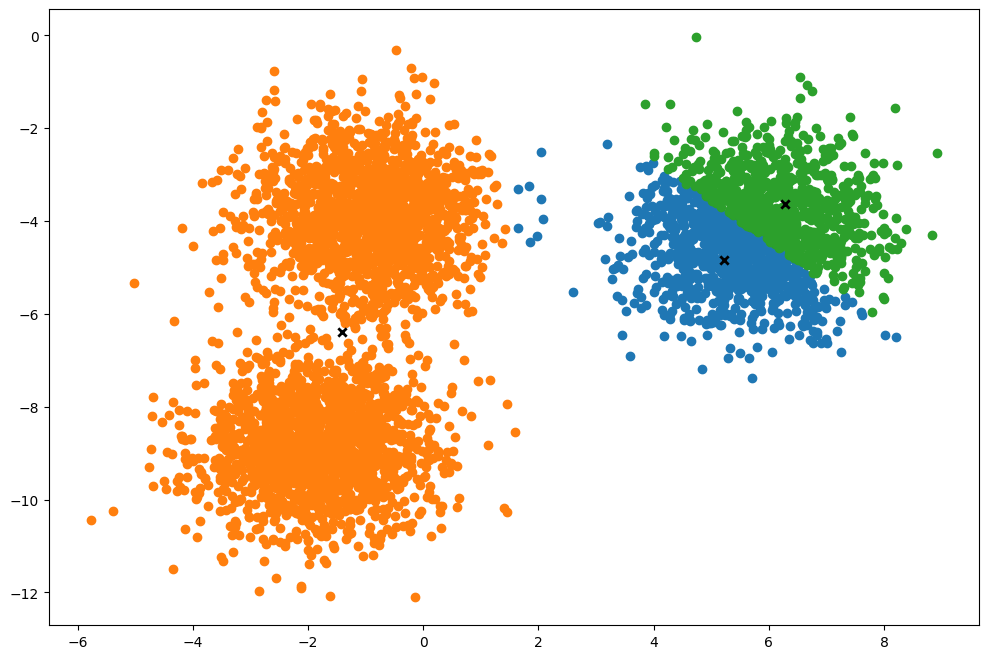

In [201]:
from sklearn.datasets import make_blobs
from time import perf_counter
start_time = perf_counter()
X, y = make_blobs(
    centers=3, n_samples=5000, n_features=2, shuffle=True, random_state=40
)
X, y = torch.tensor(X), torch.tensor(y)
print(X.shape)

clusters = len(np.unique(y))
print(clusters)
k = KMeansTorch(K=clusters, max_iters=150, plot_steps=True)
y_pred = k.predict(X,debug = False)
end_time = perf_counter()
print(f"Time taken: {end_time-start_time}")
k.plot()

- However, optimized PyTorch version was a bit quicker than vectorized numpy implementation (.004 seconds vs .007 seconds).